## Libraries

In [1]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

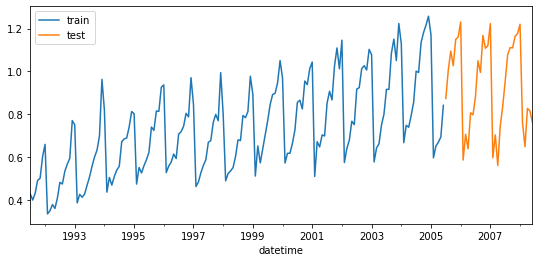

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Prediction intervals

In [6]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, max_depth=3),
                lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=3, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Window size: 15 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2021-12-08 00:28:35 
Last fit date: 2021-12-08 00:28:35 
Skforecast version: 0.4.0 

In [10]:
# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = 36,
                    interval = [5, 95],
                    n_boot   = 250
              )

predictions.head(4)

,pred,lower_bound,upper_bound
2005-07-01,0.899283,0.832109,0.977063
2005-08-01,0.954796,0.881798,1.022032
2005-09-01,1.066722,0.964466,1.132466
2005-10-01,1.102195,1.017766,1.174206


In [14]:
print(predictions.head(4).to_markdown())

|                     |     pred |   lower_bound |   upper_bound |
|:--------------------|---------:|--------------:|--------------:|
| 2005-07-01 00:00:00 | 0.899283 |      0.832109 |      0.977063 |
| 2005-08-01 00:00:00 | 0.954796 |      0.881798 |      1.02203  |
| 2005-09-01 00:00:00 | 1.06672  |      0.964466 |      1.13247  |
| 2005-10-01 00:00:00 | 1.1022   |      1.01777  |      1.17421  |


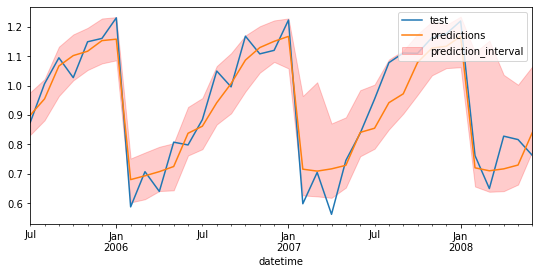

In [12]:
fig, ax=plt.subplots(figsize=(9, 4))
data_test.plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2,
    label = 'prediction_interval'
)
ax.legend(loc='upper right');